# Tweet sentiment analysis - Group 2

The approach consists in testing a Naive Bayes baseline model 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from tqdm.notebook import tqdm # progress bars
import re # RegEx
import string

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# general NLP preprocessing and basic tools
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet

# train/test split
from sklearn.model_selection import train_test_split
# basic machine learning models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
# our evaluation metric for sentiment classification
from sklearn.metrics import fbeta_score

from easydict import EasyDict

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# install HuggingFace's transformers library
! pip install transformers

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eurecom-aml-2023-challenge-3/sample_submission.csv
/kaggle/input/eurecom-aml-2023-challenge-3/train.csv
/kaggle/input/eurecom-aml-2023-challenge-3/test.csv


## Loading the data

In [4]:
train_df = pd.read_csv('/kaggle/input/eurecom-aml-2023-challenge-3/train.csv')
test_df = pd.read_csv('/kaggle/input/eurecom-aml-2023-challenge-3/test.csv')

## Quick data inspection

In [5]:
len(train_df)+len(test_df)

27480

In [6]:
train_df.head()

,textID,text,selected_text,sentiment
0,28ac06f416,good luck with your auction,good luck with your auction,positive
1,92098cf9a7,Hmm..You can`t judge a book by looking at its ...,Hmm..You can`t judge a book by looking at its ...,neutral
2,7858ff28f2,"Hello, yourself. Enjoy London. Watch out for ...",They`re mental.,negative
3,b0c9c67f32,We can`t even call you from belgium sucks,m suck,negative
4,7b36e9e7a5,not so good mood..,not so good mood..,negative


In [7]:
test_df.head()

,textID,text,selected_text
0,102f98e5e2,Happy Mother`s Day hahaha,Happy Mother`s Day
1,033b399113,"Sorry for the triple twitter post, was having ...","Sorry for the triple twitter post, was having ..."
2,c125e29be2,thats much better than the flu syndrome!,thats much better
3,b91e2b0679,Aww I have a tummy ache,tummy ache
4,1a46141274,hey chocolate chips is good. i want a snack ...,good.


## Data exploration

### Positive, Neutral & Negative data points

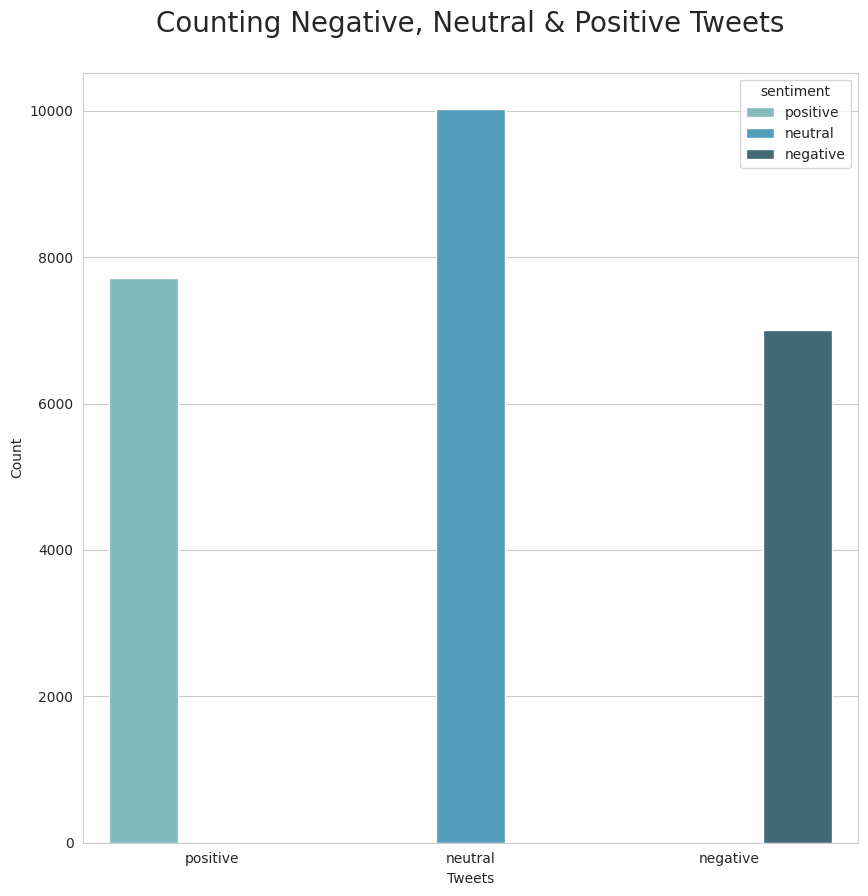

In [8]:
plt.figure(figsize=(10,10))
sns.countplot(data=train_df, x='sentiment', hue='sentiment', palette=sns.color_palette("GnBu_d", 3))
plt.title("Counting Negative, Neutral & Positive Tweets\n",fontsize=20)
plt.xlabel('Tweets')
plt.ylabel("Count")
plt.show()

### Length of tweets

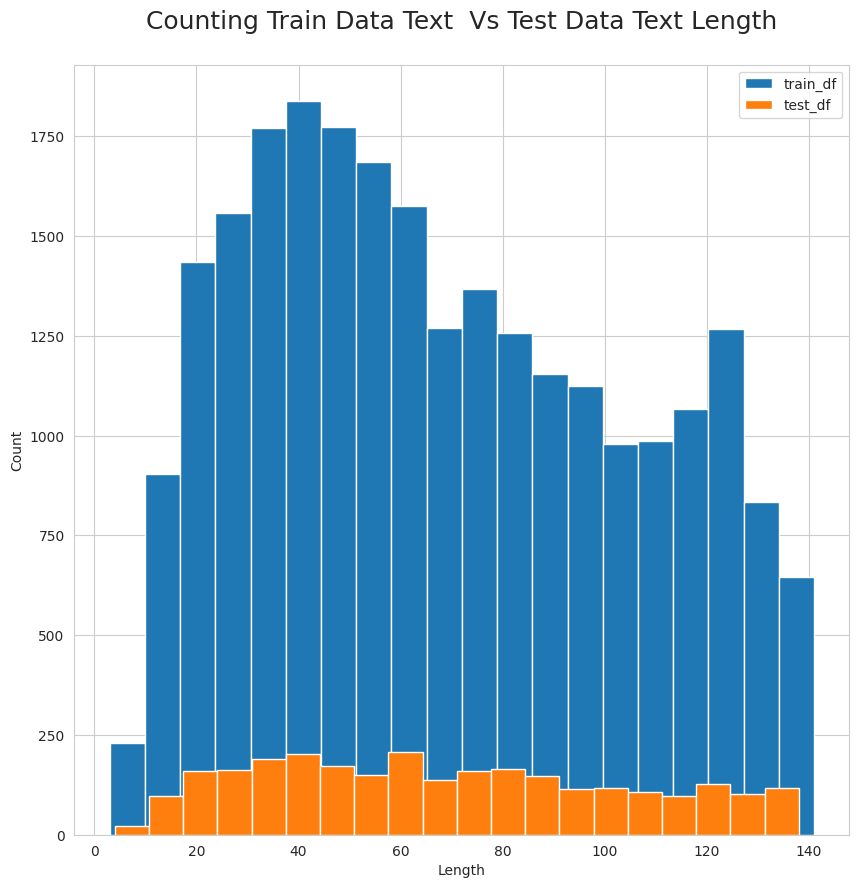

In [9]:
tweet_len_train = train_df["text"].str.len()
tweet_len_test = test_df["text"].str.len()

plt.figure(figsize=(10,10))
plt.hist(tweet_len_train, bins=20,label='train_df')
plt.hist(tweet_len_test , bins=20, label='test_df')
plt.title("Counting Train Data Text  Vs Test Data Text Length\n",fontsize=18)
plt.xlabel('Length')
plt.ylabel("Count")
plt.legend()
plt.show()

Are there any differences in length for positive, neutral and negative tweets?

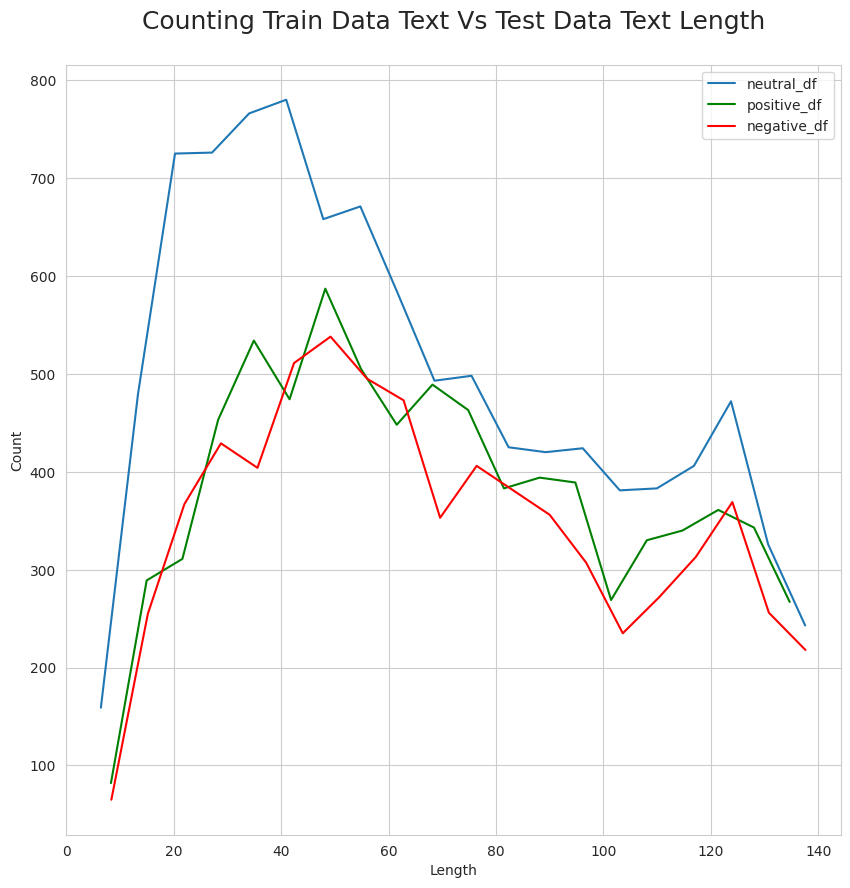

In [10]:
# datasett der bare negative er 
negative_df = train_df[train_df['sentiment'] == "negative"]
# datasett der bare nøytrale er
neutral_df = train_df[train_df['sentiment'] == "neutral"]
# datasett der bare positive er
positive_df = train_df[train_df['sentiment'] == "positive"]

tweet_len_neg = negative_df["text"].str.len()
tweet_len_neu = neutral_df["text"].str.len()
tweet_len_pos = positive_df["text"].str.len()

plt.figure(figsize=(10,10))

# Compute histogram for tweet_len_neu
counts_neu, bin_edges_neu = np.histogram(tweet_len_neu, bins=20)
counts_neu = counts_neu
bin_centers_neu = (bin_edges_neu[:-1] + bin_edges_neu[1:]) / 2.
plt.plot(bin_centers_neu, counts_neu, label='neutral_df')

# Compute histogram for tweet_len_pos
counts_pos, bin_edges_pos = np.histogram(tweet_len_pos, bins=20)
counts_pos = counts_pos
bin_centers_pos = (bin_edges_pos[:-1] + bin_edges_pos[1:]) / 2.
plt.plot(bin_centers_pos, counts_pos, label='positive_df', color='green')

# Compute histogram for tweet_len_neg
counts_neg, bin_edges_neg = np.histogram(tweet_len_neg, bins=20)
counts_neg = counts_neg
bin_centers_neg = (bin_edges_neg[:-1] + bin_edges_neg[1:]) / 2.
plt.plot(bin_centers_neg, counts_neg, label='negative_df', color='red')

plt.title("Counting Train Data Text Vs Test Data Text Length\n", fontsize=18)
plt.xlabel('Length')
plt.ylabel("Count")
plt.legend()
plt.show()

**write conclusions**

### Average word length for each sentiment

In [11]:
negative_df["avg_word_len"] = negative_df["text"].apply(lambda x: 1/(len(x.split()))*sum([len(w) for w in x.split()]))
average_negative = negative_df["avg_word_len"].mean()
print("Average word length for negative tweets:", average_negative)

neutral_df["avg_word_len"] = neutral_df["text"].apply(lambda x: 1/(len(x.split()))*sum([len(w) for w in x.split()]))
average_neutral = neutral_df["avg_word_len"].mean()
print("Average word length for neutral tweets:", average_neutral)

positive_df["avg_word_len"] = positive_df["text"].apply(lambda x: 1/(len(x.split()))*sum([len(w) for w in x.split()]))
average_positive = positive_df["avg_word_len"].mean()
print("Average word length for positive tweets:", average_positive)

Average word length for negative tweets: 4.35533043832773
Average word length for neutral tweets: 4.466700855843504
Average word length for positive tweets: 4.533448984672624


/tmp/ipykernel_32/3162887586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df["avg_word_len"] = negative_df["text"].apply(lambda x: 1/(len(x.split()))*sum([len(w) for w in x.split()]))
/tmp/ipykernel_32/3162887586.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neutral_df["avg_word_len"] = neutral_df["text"].apply(lambda x: 1/(len(x.split()))*sum([len(w) for w in x.split()]))
/tmp/ipykernel_32/3162887586.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In conclusion, the average word length does not vary much among the different sentiments.

### Word clouds visualization per class

In [12]:
! wget 'https://pic.onlinewebfonts.com/svg/img_438169.png'

--2023-06-09 14:10:01--  https://pic.onlinewebfonts.com/svg/img_438169.png
Resolving pic.onlinewebfonts.com (pic.onlinewebfonts.com)... 107.161.18.231
Connecting to pic.onlinewebfonts.com (pic.onlinewebfonts.com)|107.161.18.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/png]
Saving to: ‘img_438169.png’

img_438169.png          [ <=>                ]  12.46K  --.-KB/s    in 0s      

2023-06-09 14:10:02 (185 MB/s) - ‘img_438169.png’ saved [12758]



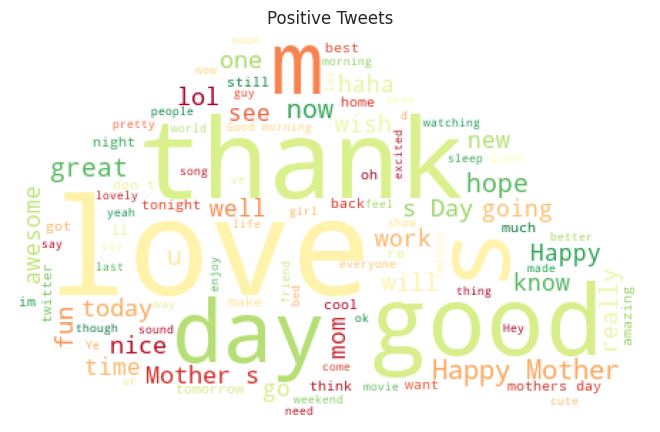

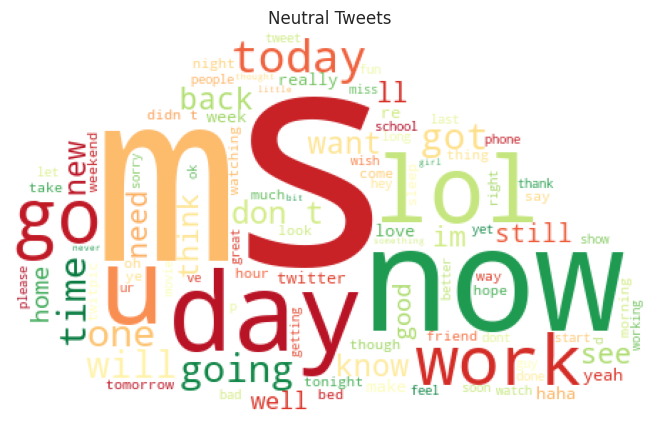

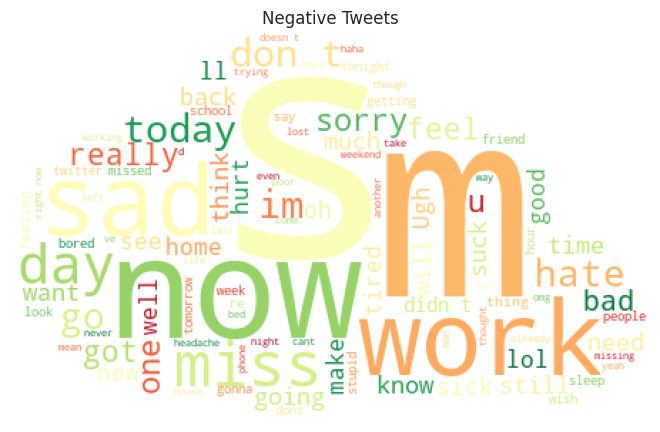

In [13]:
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
stopword = set(STOPWORDS)
import requests
from io import BytesIO
from PIL import Image

# From URL
response = requests.get("https://raw.githubusercontent.com/R-CoderDotCom/samples/main/wordcloud-mask-2.jpg")
wordcloud_mask = np.array(Image.open(BytesIO(response.content)))

positive_tweet_text=" ".join(positive_df["text"].tolist())

wordcloud=WordCloud(stopwords=stopword,width=500,height=500,mask=wordcloud_mask,max_words=100,colormap='RdYlGn', background_color="white").generate(positive_tweet_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.title("Positive Tweets")
plt.show()

neutral_tweet_text=" ".join(neutral_df["text"].tolist())

wordcloud=WordCloud(stopwords=stopword,width=500,height=500,mask=wordcloud_mask,max_words=100,colormap='RdYlGn', background_color="white").generate(neutral_tweet_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.title("Neutral Tweets")
plt.show()

negative_tweet_text=" ".join(negative_df["text"].tolist())

wordcloud=WordCloud(stopwords=stopword,width=500,height=500,mask=wordcloud_mask,max_words=100,colormap='RdYlGn', background_color="white").generate(negative_tweet_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.title("Negative Tweets")
plt.show()

### Emojis

In [14]:
import emoji

Count the number of emojis present in the whole dataset

In [ ]:
emoji_list = list(emoji.EMOJI_DATA.keys())
count_emoji = 0
for tw in train_df.text:
    words = tw.split(' ') # separate words by white spaces
    for w in words:
        if w in emoji_list:
            count_emoji += 1
print(f'Number of emojis in the whole training dataset: {count_emoji}')

### Emoticons

In [ ]:
! pip install emot

In [ ]:
from emot.emo_unicode import EMOTICONS_EMO

Insert some common emoticons in the EMOTICONS_EMO dictionary that are currently missing:

In [ ]:
EMOTICONS_EMO['<3']='heart'
EMOTICONS_EMO['*-*']='dreamy face'
EMOTICONS_EMO['*_*']='dreamy face'

Count the emoticons present in the whole dataset

In [ ]:
count_emoticons = 0
for tw in train_df.text:
    words = tw.split(' ')
    for w in words:
        if w in EMOTICONS_EMO:
            count_emoticons += 1
print(f'Number of emoticons in the whole training dataset: {count_emoticons}')

In [ ]:
count_emoticons = 0

for tw in negative_df.text:
    words = tw.split(' ')
    for w in words:
        if w in EMOTICONS_EMO:
            count_emoticons += 1
print(f'Average number of emoticons in the negative tweets: {count_emoticons/len(negative_df.index)}')
print(f'Total number of emoticons in the negative tweets: {count_emoticons}')

In [ ]:
count_emoticons = 0

for tw in neutral_df.text:
    words = tw.split(' ')
    for w in words:
        if w in EMOTICONS_EMO:
            count_emoticons += 1
print(f'Average number of emoticons in the neutral tweets: {count_emoticons/len(neutral_df)}')
print(f'Total number of emoticons in the neutral tweets: {count_emoticons}')

In [ ]:
count_emoticons = 0

for tw in positive_df.text:
    words = tw.split(' ')
    for w in words:
        if w in EMOTICONS_EMO:
            count_emoticons += 1
print(f'Average number of emoticons in the positive tweets: {count_emoticons/len(positive_df)}')
print(f'Total number of emoticons in the positive tweets: {count_emoticons}')

### Punctuation frequency
The absence of punctuation or minimal use of punctuation might indicate a more neutral or objective tone.

In [ ]:
def calculate_punctuation_count(tweet):
    count = sum([1 for char in tweet if char in string.punctuation])
    return count

negative_punctuation_freq = negative_df["text"].apply(calculate_punctuation_count).mean()
print("Punctuation frequency of negative tweets: ",negative_punctuation_freq)

neutral_punctuation_freq = neutral_df["text"].apply(calculate_punctuation_count).mean()
print("Punctuation frequency of neutral tweets: ",neutral_punctuation_freq)

positive_punctuation_freq = positive_df["text"].apply(calculate_punctuation_count).mean()
print("Punctuation frequency of positive tweets: ",positive_punctuation_freq)

However, no significant differences are found in puntuation frequency for the different sentiments.

### Data exploration conclusions
All in all, no relevant meta information that could aid the sentiment analysis task can be extracted from the data at hand. Emojis are absent, emoticons and hashtags are very rare and average word lengths/punctuation frequencies are very similar among the different sentiments.

## Data pre-processing

### Text cleaning

In [ ]:
stopwords = set(STOPWORDS)
stopwords.update(["nan"])

In [ ]:
# Function for converting emoticons into word
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        pattern = re.escape(emot)  # Escape the parentheses in the emoticon
        text = re.sub(pattern, "_".join(EMOTICONS_EMO[emot].replace(",","").split()), text)
    return text

In [ ]:
# Example
text = "Hello :-) :-)"
convert_emoticons(text)

In [ ]:
def text_clean(x, heavy=False):
    ### Light
    x = x.lower() # lowercase everything
    x = x.encode('ascii', 'ignore').decode()  # remove unicode characters
    x = re.sub(r'https*\S+', ' ', x) # remove links
    x = re.sub(r'http*\S+', ' ', x)
    # cleaning up text
    x = re.sub(r'\'\w+', '', x) 
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)
    
    ### Heavy
    if heavy:
        x = ' '.join([word for word in x.split(' ') if word not in stopwords])
        x = re.sub(r'@\S', '', x) # remove user handles
        x = re.sub(r'#\S+', ' ', x) # remove hashtags
        x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
        # remove single letters and numbers surrounded by space
        x = re.sub(r'\s[a-z]\s|\s[0-9]\s', ' ', x)
        x = convert_emoticons(x) # convert emoticons into word
        

    return x

### Lemmatization (heavy cleaning)
This is where a library of words is used to remove the inflectional endings of words to return them to their base form, which is known as the lemma. For example, instead of “running” or “runs”, we would just get “run”.

In [ ]:
# Download WordNet data
nltk.data.path.append('/kaggle/working/nltk_data')
nltk.download('wordnet', quiet=True, raise_on_error=True, download_dir='/kaggle/working/nltk_data')

In [ ]:
import zipfile

# Specify the path to the WordNet corpus zip file
wordnet_zip_path = '/kaggle/working/nltk_data/corpora/wordnet.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(wordnet_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/nltk_data/corpora/')

In [ ]:
def lemmatize_word(word, tag):
    tag_mapping = {
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV,
        'J': wordnet.ADJ
    }
    tag = tag_mapping.get(tag[0], wordnet.NOUN)

    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word, tag)

In [ ]:
def lemmatize_tweet(tweet):
    tokens = word_tokenize(tweet)
    tagged_tokens = pos_tag(tokens)
    lemmatized_tokens = [lemmatize_word(token, tag) for token, tag in tagged_tokens]
    return ' '.join(lemmatized_tokens)

The pos_tag() function from the NLTK library is used to assign part-of-speech (POS) tags to words in a given sentence or text. POS tagging is the process of labeling the words in a text with their respective parts of speech, such as nouns, verbs, adjectives, adverbs, etc.

In [ ]:
# we create a validation dataset from the training data
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=0)

We start off by converting the labels to numbers. This is a requirement for the submission and numerical inputs are generally more compatible with machine learning libraries.

In [ ]:
target_conversion = {
    'neutral': 0,
    'positive': 1,
    'negative': 2
}

In [ ]:
train_df['target'] = train_df['sentiment'].map(target_conversion)
val_df['target'] = val_df['sentiment'].map(target_conversion)

### Config dictionary

In [ ]:
config = {
    "models":["bert-base-uncased","roberta-base","cardiffnlp/twitter-roberta-base-sentiment"],
    "model_name":"roberta-base",
    "dataloaders":{
        "train_batch_size": 4,
        "val_batch_size": 32
    },
    "optim":{
        "lr": 1e-5,
        "eps": 1e-8
    }
}

config = EasyDict(config)

## Training a simple classifier (Baseline)

We are training a naive Bayes classifier on the Bag-of-Words features of the training data:

https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html

It is already built into the sklearn library:

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

Keep in mind that not only storing the features is challenging but also processing them. A simple SVM may be quite slow on such high-dimensional features. Naive Bayes works well with Bag-of-Words.



## Test 1: apply Light cleaning, no lemmatization

In [ ]:
train_df['cleaned_text'] = train_df.text.apply(text_clean, heavy=False)
val_df['cleaned_text'] = val_df.text.apply(text_clean, heavy=False)
test_df['cleaned_text'] = test_df.text.apply(text_clean, heavy=False)

### Bag-of-words with CountVectorizer()

In [ ]:
count_vect = CountVectorizer()

In [ ]:
# here we are obtaining the vocabulary from the training data minus validation data
# you may want to change this to the full training data for the final submission
X_train_counts = count_vect.fit_transform(list(train_df['cleaned_text'].values))
X_val_counts = count_vect.transform(list(val_df['cleaned_text'].values))
X_test_counts = count_vect.transform(list(test_df['cleaned_text'].values))

In [ ]:
print('Train feature shape:', X_train_counts.shape)
print('Train feature shape:', X_val_counts.shape)
print('Test feature shape:', X_test_counts.shape)

### Naive Bayes classifier

In [ ]:
%%time
clf = MultinomialNB().fit(X_train_counts, train_df['target'])

In [ ]:
val_predictions_nb = clf.predict(X_val_counts)

In [ ]:
accuracy = (val_predictions_nb == val_df['target'].values).mean()
print('The accuracy of our multinomial Naive Bayes classifier with Light cleaning is: {:.2f}%'.format(accuracy*100))

In [ ]:
fbeta = fbeta_score(val_df['target'].values, val_predictions_nb, average='macro', beta=1.0)
print('The fbeta score is:', fbeta)

## Test 2: apply Heavy cleaning + lemmatization

In [44]:
train_df['cleaned_text'] = train_df.text.apply(text_clean, heavy=True)
val_df['cleaned_text'] = val_df.text.apply(text_clean, heavy=True)
test_df['cleaned_text'] = test_df.text.apply(text_clean, heavy=True)

In [45]:
# apply lemmatization to the sets
train_df['text_lemmatized'] = train_df.cleaned_text.apply(lemmatize_tweet)
val_df['text_lemmatized'] = val_df.cleaned_text.apply(lemmatize_tweet)
test_df['text_lemmatized'] = test_df.cleaned_text.apply(lemmatize_tweet)

### Bag-of-words with CountVectorizer()

In [46]:
count_vect = CountVectorizer()

In [47]:
# here we are obtaining the vocabulary from the training data minus validation data
# you may want to change this to the full training data for the final submission
X_train_counts = count_vect.fit_transform(list(train_df['text_lemmatized'].values))
X_val_counts = count_vect.transform(list(val_df['text_lemmatized'].values))
X_test_counts = count_vect.transform(list(test_df['text_lemmatized'].values))

In [48]:
print('Train feature shape:', X_train_counts.shape)
print('Train feature shape:', X_val_counts.shape)
print('Test feature shape:', X_test_counts.shape)

Train feature shape: (22258, 19838)
Train feature shape: (2474, 19838)
Test feature shape: (2748, 19838)


### Naive Bayes classifier

In [49]:
%%time
clf = MultinomialNB().fit(X_train_counts, train_df['target'])

CPU times: user 8.73 ms, sys: 958 µs, total: 9.69 ms
Wall time: 9.17 ms


In [50]:
val_predictions_nb = clf.predict(X_val_counts)

In [51]:
accuracy = (val_predictions_nb == val_df['target'].values).mean()
print('The accuracy of our multinomial Naive Bayes classifier with Heavy cleaning + lemmatization is: {:.2f}%'.format(accuracy*100))

The accuracy of our multinomial Naive Bayes classifier with Heavy cleaning + lemmatization is: 64.63%


In [52]:
fbeta = fbeta_score(val_df['target'].values, val_predictions_nb, average='macro', beta=1.0)
print('The fbeta score is:', fbeta)

The fbeta score is: 0.6469736944969088


##  Loading Tokenizer and Encoding our Data

In [53]:
from transformers import AutoTokenizer
from torch.utils.data import TensorDataset

### Check emoticons compatibility of the chosen model

In [54]:
for mod in config.models:
    tokenizer = AutoTokenizer.from_pretrained(
        mod,
        do_lower_case=True
    )
    cnt = 0
    for e in EMOTICONS_EMO:
        tokenized = tokenizer.decode(tokenizer.encode(e)).strip("</s>").strip()
        if e not in tokenized:
            cnt += 1
    print(f"{cnt/len(emoji_list)} of the emojis are not identified by the tokenizer of model: {mod}.")

0.046482146630044366 of the emojis are not identified by the tokenizer of model: bert-base-uncased.


0.005493344601732516 of the emojis are not identified by the tokenizer of model: roberta-base.


0.005493344601732516 of the emojis are not identified by the tokenizer of model: cardiffnlp/twitter-roberta-base-sentiment.


As can be seen by the results, the tokenizers of all the models considered recognize almost all the emoticons present in the emot.EMOTICONS_EMO base.

Since Twitter-RoBERTa was trained specifically for the task of tweets sentiment analysis, we chose to implement it.

Given that the chosen model is already able to recognize almost all the emoticons, no special conversion is applied.

In [55]:
config.model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(
    config.model_name,
    do_lower_case=True
)

### Test with Light cleaning

In [56]:
train_df['cleaned_text'] = train_df.text.apply(text_clean, heavy=False)
val_df['cleaned_text'] = val_df.text.apply(text_clean, heavy=False)
test_df['cleaned_text'] = test_df.text.apply(text_clean, heavy=False)

### Encoding training and validation data

In [57]:
encoded_data_train = tokenizer.batch_encode_plus(
    list(train_df.cleaned_text.values),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    list(val_df.cleaned_text.values),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.target.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.target.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [58]:
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val, 
                            attention_masks_val,
                           labels_val)

In [59]:
len(dataset_train)

22258

In [60]:
dataset_val.tensors

(tensor([[    0,   891,   360,  ...,     1,     1,     1],
         [    0,  8877,   399,  ...,     1,     1,     1],
         [    0,  1039,  1215,  ...,     1,     1,     1],
         ...,
         [    0,   295,  9877,  ...,     1,     1,     1],
         [    0, 29784,   939,  ...,     1,     1,     1],
         [    0,  2678,     8,  ...,     1,     1,     1]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 0, 0,  ..., 1, 0, 2]))

## Setting up the pretrained model

In [61]:
from transformers import AutoModelForSequenceClassification

In [62]:
model = AutoModelForSequenceClassification.from_pretrained(
                                      config.model_name, 
                                      num_labels = len(target_conversion),
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )

## Creating Data Loaders

In [63]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [64]:
dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=config.dataloaders.train_batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=config.dataloaders.val_batch_size
)

## Setting Up Optimizer and Scheduler

In [65]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [66]:
optimizer = AdamW(
    model.parameters(),
    lr = config.optim.lr,
    eps = config.optim.eps
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [67]:
epochs = 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = len(dataloader_train)*epochs
)

## Defining our Performance Metrics

import numpy as np
from sklearn.metrics import f1_score



In [68]:
import numpy as np
from sklearn.metrics import f1_score

In [69]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'macro')

In [70]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Creating our Training Loop

In [71]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [73]:
def evaluate(dataloader_val):
    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

### Training loop

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
    
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total +=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
    
    #torch.save(model.state_dict(), f'Models/BERT_ft_Epoch{epoch}.model')
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (macro): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/5565 [00:00<?, ?it/s]

## Evaluating our Model

In [ ]:
accuracy_per_class(predictions, true_vals)

# Creating a submission

In [ ]:
# Creating a submission

X_train_counts = count_vect.fit_transform(list(train_df['text'].values) + list(val_df['text'].values))
X_test_counts = count_vect.transform(list(test_df['text'].values))

clf = MultinomialNB().fit(X_train_counts, np.hstack([train_df['target'].values, val_df['target'].values]))
test_predictions_nb = clf.predict(X_test_counts)

submission_df = pd.DataFrame()
submission_df['textID'] = test_df['textID']
submission_df['sentiment'] = test_predictions_nb
submission_df.to_csv('TA_baseline_NB.csv', index=False)

## How good is this score?

Early approaches in NLP used rule-based classifiers for sentiment analysis. A popular baseline is VADER which was published in 2014:

https://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/viewPaper/8109

VADER does not use any machine learning but is purely handcrafted by humans. It uses text preprocessing and lexica to determine the sentiment of a text.

In [ ]:
nltk.download('vader_lexicon')

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
# We show a few prediction examples:
for doc in val_df['text'].iloc[:5].values:
    print(doc)
    print(sid.polarity_scores(doc))

In [ ]:
def vader_predict(x):
    prediction = sid.polarity_scores(x)
    prediction_list = [
        (1, prediction['pos']),
        (-1, prediction['neg']),
        (0, prediction['neu'])
    ]
    label = sorted(prediction_list, key=lambda x: x[1], reverse=True)[0][0]
    return label

In [ ]:
predictions_vader = val_df['text'].apply(vader_predict)

In [ ]:
accuracy = (predictions_vader == val_df['target'].values).mean()
print('The accuracy of VADER is: {:.2f}%'.format(accuracy*100))

In [ ]:
fbeta = fbeta_score(val_df['target'].values, predictions_vader, average='macro', beta=1.0)
print('The fbeta score is:', fbeta)

VADER performs worse! That is a good sign that our classifier learned useful generalizations from the training data (better than standard handcrafted rules).

## Where to go from here?

We can improve our Machine Learning pipeline on multiple aspects:

### Data analysis:
How is the data distributed? Can we analyze our data to find patterns associated with the classes? Which kinds of words are useful, which aren't?

### Feature extraction:
Can we make our Bag-of-Words representation more compact or richer? There are many things you could try to implement. Here are some buzzwords: tokenization, stop words removal, lemmatization, n-gram extraction, ...
A useful Python library to address these issues is: NLTK (https://www.nltk.org/)
The sklearn CountVectorizer we used can be combined with NLTK preprocessing: https://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes
Is there also a dense (as opposed to sparse) representation of documents (tweets in our case)? Buzzwords: word2vec, gloVe
The state-of-the-art: ... are neural network language models, so-called Transformers. There are pretrained models available. If you feel comfortable with neural networks, fine-tuning and GPUs, have a look here: https://huggingface.co/transformers/

In general, we also recommend spaCy as a convenient Python library that covers most of the above features at once and may be a great resource to start with: https://spacy.io/

### Model selection:
The model of choice highly depends on the previously extracted features. Depending on whether you obtain a sparse or dense feature representation, you have to choose an appropriate model!

### Model evaluation:
Make sure to select potential model hyperparameters using cross-validation or similar. Our evaluation metric of choice is the F1-score:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score

We choose beta=1 and average=macro

### Extension idea 1:
Apart from classifying the sentiment of tweets, we can also try to determine which words are the reason for the classifier to determine the classification. Ground-truth labels for these words are contained in our training data. The evaluation will not take place on the Kaggle platform. You need to do it yourself. Use the Jaccard coefficient to evaluate the overlap between the selected words and the ground truth:

https://scikit-learn.org/stable/modules/model_evaluation.html#jaccard-similarity-coefficient-score

In [ ]:
# selected_text shows the words selected from text to lead to the classification stored in sentiment
train_df[['text', 'selected_text', 'sentiment']].iloc[:5]

### Extension idea 2:

You may want to give it a try to Kaggle's brand new feature called models!